<p style="font-size:78px">Final Project IRWA (2024-2025)</p>

# Part 3: Ranking

In [98]:
# Standard library imports
import os
import sys

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Local application imports
current_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else os.getcwd()
project_root = os.path.join(current_dir, '..')
if project_root not in sys.path:
    sys.path.append(project_root)
import irwa.loading as ild 
import irwa.preprocessing as ipp
import irwa.indexing as ind
import irwa.ranking as irk
import irwa.evaluation as eva
import irwa.saving as sa

# The following lines allow for autoreload of modules. They allow changes in modules without the need to reload the kernel.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
# Loading
file_path = '../data/farmers-protest-tweets.json'
tweets = ild.load_tweets_from_json(file_path)
print(f"Loaded {len(tweets)} tweets")

# Preprocessing
tweet_document_ids_map_df = "../data/tweet_document_ids_map.csv"
docid_to_tweetid, token_tweets = ipp.create_tokenized_dictionary(tweets, tweet_document_ids_map_df)
print(f"Loaded {len(token_tweets)} documents with their corresponding tokenized tweet content")

Loaded 117407 tweets
Loaded 48429 documents with their corresponding tokenized tweet content


### Query: What is the indian protest?

In [100]:
query = "What is the indian protest?"          

## a) Tf-idf

In [101]:
# Create inverted index
inverted_index, tf, idf = ind.create_inverted_index_tf_idf(token_tweets)

In [102]:
# Ranking results with TF-IDF
ranked_documents_tf_idf = irk.rank_documents_tf_idf(ipp.build_terms(query), token_tweets, inverted_index, tf, idf, document_filtering=irk.conjunctive_filtering)
irk.display_scores_tf_idf(ranked_documents_tf_idf, docid_to_tweetid, tweets, 20)

sa.save_scores_to_csv(ranked_documents_tf_idf, filename="../data/tf_idf_ranking.csv")

Top 20 Results:
------------------------------------------------------------
RESULT 1
Document doc_34729: 5.031061026856039
Content: Indian farmers' protests: Why they matter to British Indians
#FarmersProtest  https://t.co/kyCWnDVyEm
------------------------------------------------------------
RESULT 2
Document doc_19653: 4.865420574825832
Content: @PunYaab Farmers are Indian ... Each n every person in protest is Indian first ... So think before tweets against protesters 

#farmersprotest
------------------------------------------------------------
RESULT 3
Document doc_33904: 4.592709354323596
Content: Indian farmers' protests: Why they matter to British Indians

#FarmersStandingFirm #FarmersProtest #StandWithFarmers 

https://t.co/ywgPhLCvm9
------------------------------------------------------------
RESULT 4
Document doc_9676: 4.485696129303427
Content: This is why Indian Farmers are protesting #FarmersProtest https://t.co/9mzFBGQaXL
-----------------------------------------------

## b) Our score

In [103]:
ranked_documents_our_score_15 = irk.rank_documents_our_score(tweets, docid_to_tweetid, ranked_documents_tf_idf, alpha=0.15, k0 = 0.5, k1=0.5,k2=1,k3=0.5)
irk.display_scores_tf_idf(ranked_documents_our_score_15, docid_to_tweetid, tweets, 20)

sa.save_scores_to_csv(ranked_documents_our_score_15, filename="../data/our_score15_ranking.csv")

Top 20 Results:
------------------------------------------------------------
RESULT 1
Document doc_23286: 1.0
Content: Arresting #ClimateChange activist #DishaRavi is a huge mistake by Indian police ! It has now taken the #FarmersProtest to another level &amp; audience ! 

The human rights of all activists &amp; protesters must be respected ! 

#FreeDishaRavi !
------------------------------------------------------------
RESULT 2
Document doc_37376: 0.20108788453315748
Content: Indian #climate activist, Disha Ravi, aged 22, has been arrested after sharing a document intended to help farmers protest against new agricultural laws @fridays_india #FarmersProtest #FarmersProtests via @BBCWorld https://t.co/WgvMNMhbnj
------------------------------------------------------------
RESULT 3
Document doc_14687: 0.19865092408436588
Content: Indian 
#FarmersProtest
Largest protest in the world..
Support Farmers
✊✊
#MSP_किसान_का_हक
#DPstopIntimidatingFarmers https://t.co/NA5kGoTlEt
-----------------

In [104]:
ranked_documents_our_score_70 = irk.rank_documents_our_score(tweets, docid_to_tweetid, ranked_documents_tf_idf, alpha=0.7, k0 = 0.5, k1=0.5,k2=1,k3=0.5)
irk.display_scores_tf_idf(ranked_documents_our_score_70, docid_to_tweetid, tweets, 20)

sa.save_scores_to_csv(ranked_documents_our_score_70, filename="../data/our_score70_ranking.csv")

Top 20 Results:
------------------------------------------------------------
RESULT 1
Document doc_23286: 1.0
Content: Arresting #ClimateChange activist #DishaRavi is a huge mistake by Indian police ! It has now taken the #FarmersProtest to another level &amp; audience ! 

The human rights of all activists &amp; protesters must be respected ! 

#FreeDishaRavi !
------------------------------------------------------------
RESULT 2
Document doc_37376: 0.2012815491648457
Content: Indian #climate activist, Disha Ravi, aged 22, has been arrested after sharing a document intended to help farmers protest against new agricultural laws @fridays_india #FarmersProtest #FarmersProtests via @BBCWorld https://t.co/WgvMNMhbnj
------------------------------------------------------------
RESULT 3
Document doc_14687: 0.1994191975811419
Content: Indian 
#FarmersProtest
Largest protest in the world..
Support Farmers
✊✊
#MSP_किसान_का_हक
#DPstopIntimidatingFarmers https://t.co/NA5kGoTlEt
-------------------

## c) BM25

#### b = 0.7

In [105]:
# Ranking results with TF-IDF
ranked_documents_bm25_b7 = irk.rank_documents_bm25(ipp.build_terms(query), token_tweets, inverted_index, tf, idf)
irk.display_scores_tf_idf(ranked_documents_bm25_b7, docid_to_tweetid, tweets, 20)

sa.save_scores_to_csv(ranked_documents_bm25_b7, filename="../data/bm25_ranking_b7.csv")

Top 20 Results:
------------------------------------------------------------
RESULT 1
Document doc_19653: 7.578828703860777
Content: @PunYaab Farmers are Indian ... Each n every person in protest is Indian first ... So think before tweets against protesters 

#farmersprotest
------------------------------------------------------------
RESULT 2
Document doc_34729: 7.556960017742792
Content: Indian farmers' protests: Why they matter to British Indians
#FarmersProtest  https://t.co/kyCWnDVyEm
------------------------------------------------------------
RESULT 3
Document doc_9676: 7.295058025055637
Content: This is why Indian Farmers are protesting #FarmersProtest https://t.co/9mzFBGQaXL
------------------------------------------------------------
RESULT 4
Document doc_33904: 7.178802751748759
Content: Indian farmers' protests: Why they matter to British Indians

#FarmersStandingFirm #FarmersProtest #StandWithFarmers 

https://t.co/ywgPhLCvm9
-----------------------------------------------

#### b = 0.15

In [106]:
# Ranking results with TF-IDF
ranked_documents_bm25_b15 = irk.rank_documents_bm25(ipp.build_terms(query), token_tweets, inverted_index, tf, idf, b= 0.15)
irk.display_scores_tf_idf(ranked_documents_bm25_b15, docid_to_tweetid, tweets, 20)

sa.save_scores_to_csv(ranked_documents_bm25_b15, filename="../data/bm25_ranking_b15.csv")

Top 20 Results:
------------------------------------------------------------
RESULT 1
Document doc_13095: 7.474697562162942
Content: INDIAN FARMERS are protesting in DELHI for last 3 months. 220+ farmers had died so far in #FarmersProtest .Protests are held all over the world to show solidarity with Indian Farmers.A protest will be held in Australia this Sunday.
#DPstopIntimidatingFarmers
@UNHumanRights
@bbc https://t.co/Ct5hqEEXRE
------------------------------------------------------------
RESULT 2
Document doc_19653: 7.351107914844778
Content: @PunYaab Farmers are Indian ... Each n every person in protest is Indian first ... So think before tweets against protesters 

#farmersprotest
------------------------------------------------------------
RESULT 3
Document doc_30537: 7.135246745964769
Content: @KahlonRav @MrBigShot01 @jjhorgan Thank you @jjhorgan for being a constant voice for Indians protesting right now. @JustinTrudeau must continue urging Indian Govnt to uphold democracy dur

## Comparison

In [107]:
# Read the CSV files
tfidf_df = pd.read_csv("../data/tf_idf_ranking.csv").head(20)
our_score_15_df = pd.read_csv("../data/our_score15_ranking.csv").head(20)
our_score_70_df = pd.read_csv("../data/our_score70_ranking.csv").head(20)
bm25_b7_df = pd.read_csv("../data/bm25_ranking_b7.csv").head(20)
bm25_b15_df = pd.read_csv("../data/bm25_ranking_b15.csv").head(20)

In [108]:
def plot_rank_comparison(dfs, score_cols, token_tweets):
    """
    Plots accumulated position points for documents across selected scoring methods.

    Parameters:
    - dfs: Dictionary where keys are method names and values are dataframes with 'Document ID' and 'score' columns.
    - score_cols: List of keys from dfs to specify which methods to compare.
    """
    # Rename columns and assign ranking points
    for name in dfs:
        dfs[name].rename(columns={'Document ID': 'document_id', 'score': f'points_{name}'}, inplace=True)
        dfs[name][f'points_{name}'] = range(20, 0, -1)  # Rank position points: 1 = 20, 2 = 19, ..., 20 = 1

    # Merge dataframes based on selected methods
    merged_df = dfs[score_cols[0]][['document_id', f'points_{score_cols[0]}']]
    for col in score_cols[1:]:
        merged_df = pd.merge(merged_df, dfs[col][['document_id', f'points_{col}']], on='document_id', how='outer')

    # Fill NaN values with 0 for documents not present in all rankings
    merged_df.fillna(0, inplace=True)

    # Calculate total points across selected methods
    merged_df['total_points'] = merged_df[[f'points_{col}' for col in score_cols]].sum(axis=1)

    # Sort documents by total points
    merged_df.sort_values(by='total_points', ascending=False, inplace=True)

    # Prepare data for stacked bar plot
    documents = merged_df['document_id']
    colors = ['skyblue', 'lightgreen', 'salmon', 'plum', 'orange']  # Predefined colors for up to 5 methods
    color_map = {col: colors[i % len(colors)] for i, col in enumerate(score_cols)}

    # Create a new list of formatted document labels with lengths
    formatted_documents = [f"{doc} ({len(token_tweets[doc])})" for doc in documents]

    # Plot
    fig, ax = plt.subplots(figsize=(9, 7))
    
    # Accumulate points for each method in a stacked manner
    left_values = [0] * len(documents)
    for col in score_cols:
        bars = ax.barh(formatted_documents, merged_df[f'points_{col}'], left=left_values, color=color_map[col], label=col)
        
        # Add point value annotations inside each bar
        for bar, value in zip(bars, merged_df[f'points_{col}']):
            if value > 0:  # Only annotate non-zero points
                value = 21 - value
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + bar.get_height() / 2,
                    f'{int(value)}',
                    ha='center', va='center', color='black', fontsize=8, weight='bold'
                )
                
        left_values = left_values + merged_df[f'points_{col}']

    # Add legend and labels
    ax.set_xlabel('Total Points (Based on Ranking Position)')
    ax.set_title('Accumulated Position Points by Document in Selected Top 20 Rankings')
    ax.legend(loc='lower right')
    
    # Show plot
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest rank at the top
    plt.tight_layout()
    plt.show()

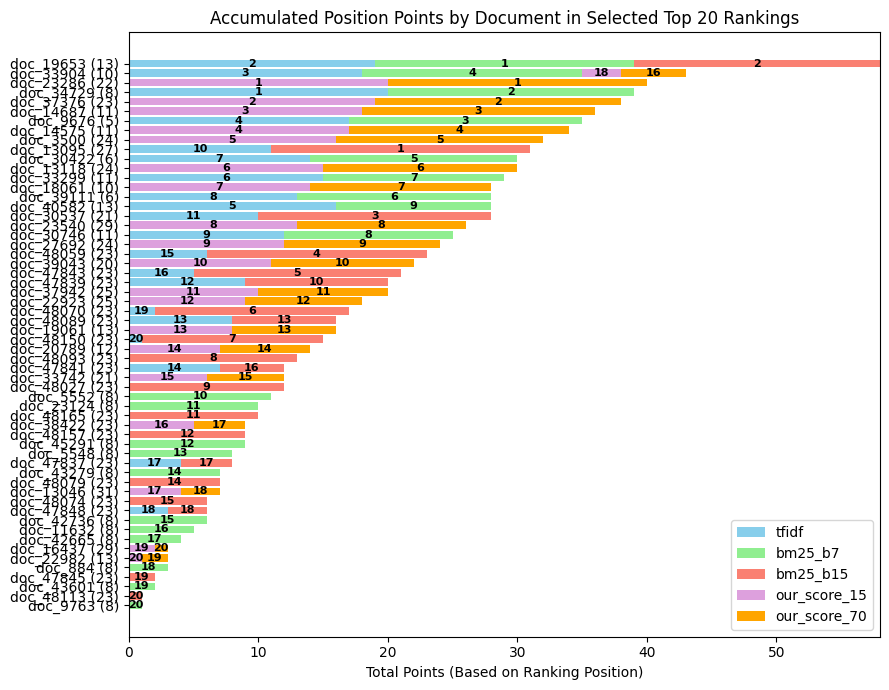

In [109]:
# Dataframes in a dictionary with custom names
dfs = {
    'tfidf': tfidf_df,
    'our_score_15': our_score_15_df,
    'our_score_70': our_score_70_df,
    'bm25_b7': bm25_b7_df,
    'bm25_b15': bm25_b15_df

}

# Plot only tfidf and bm25
plot_rank_comparison(dfs, ['tfidf','bm25_b7','bm25_b15','our_score_15', 'our_score_70'], token_tweets)

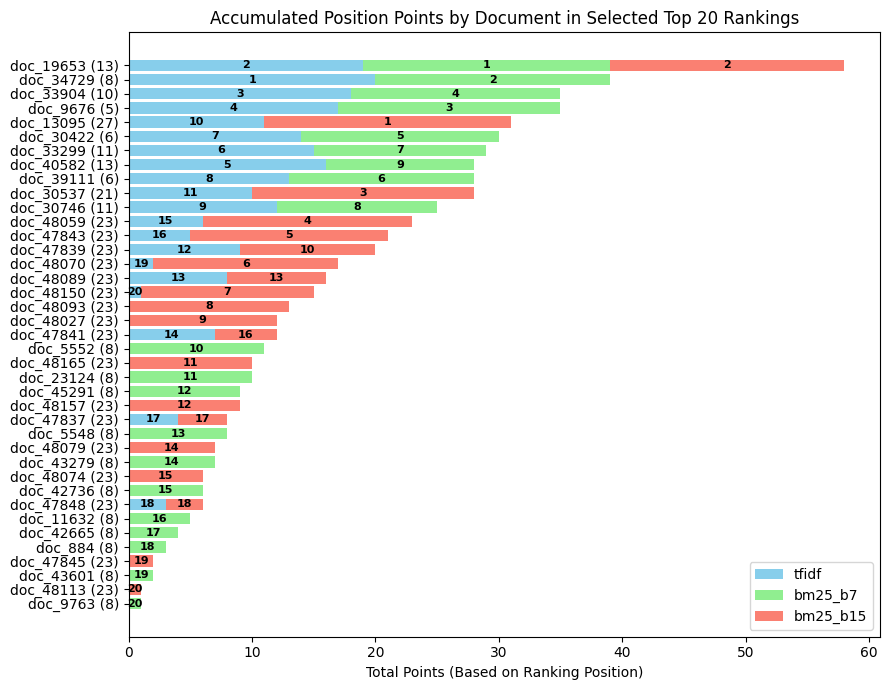

In [110]:
# Plot only tfidf and bm25
plot_rank_comparison(dfs, ['tfidf','bm25_b7', 'bm25_b15'], token_tweets)

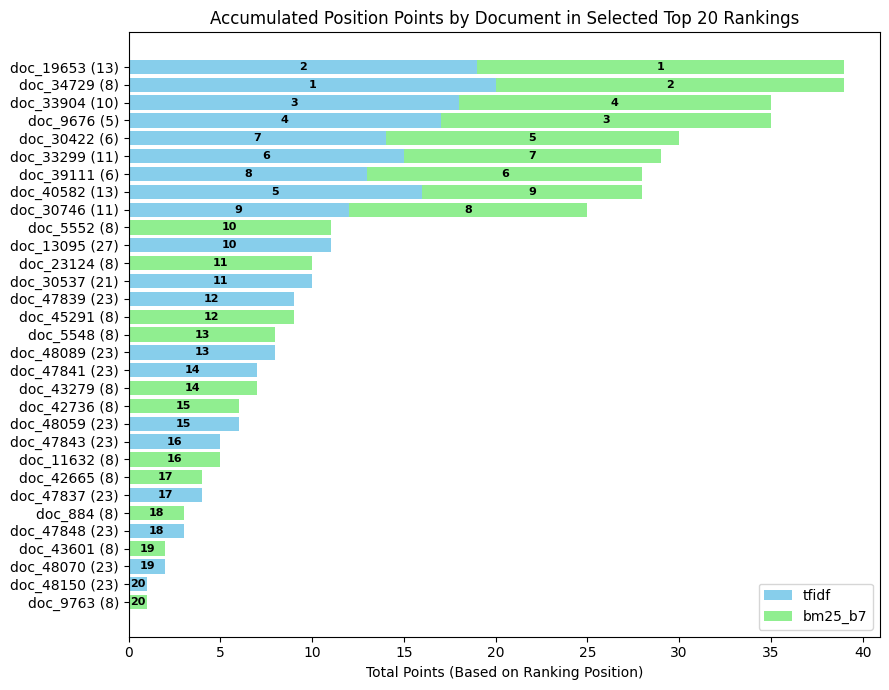

In [112]:
plot_rank_comparison(dfs, ['tfidf', 'bm25_b7'], token_tweets)

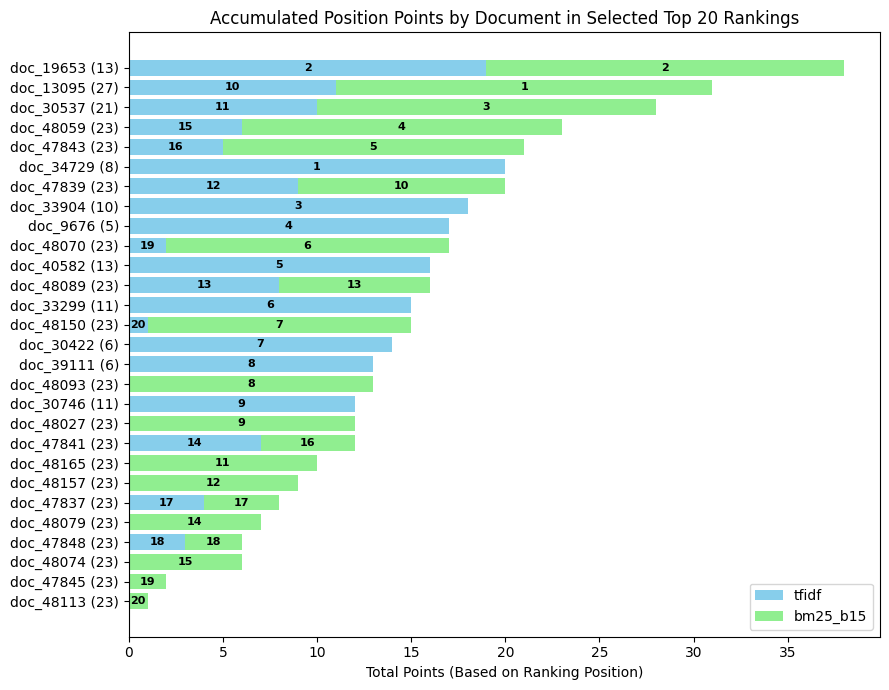

In [114]:
plot_rank_comparison(dfs, ['tfidf', 'bm25_b15'], token_tweets)

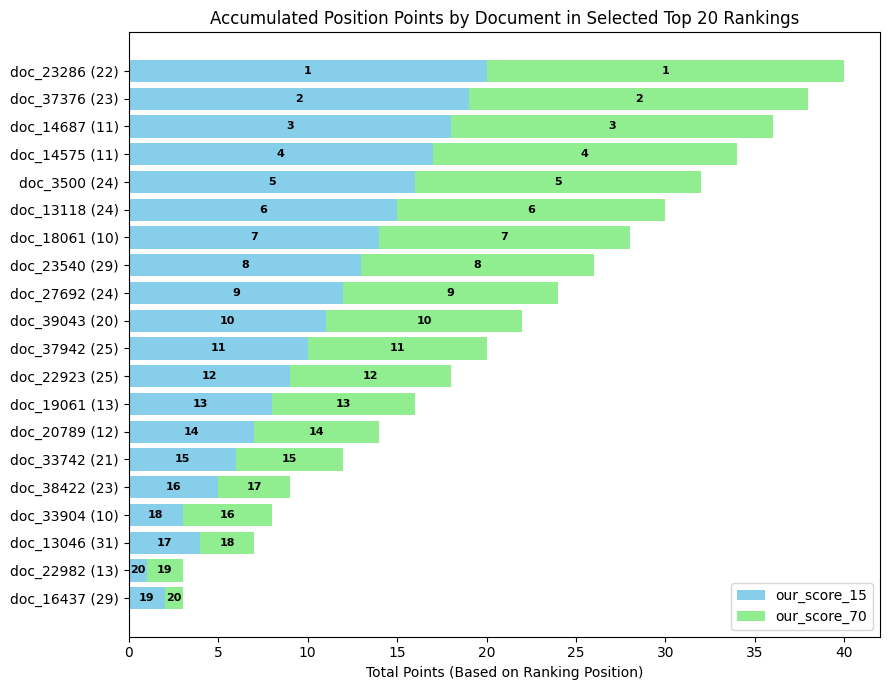

In [115]:
# Plot only tfidf and bm25
plot_rank_comparison(dfs, ['our_score_15', 'our_score_70'], token_tweets)

# Word2vec